# Final Notebook 1: Cluster Analysis and Mapping

## Cluster Analysis 

We conduct 3 cluster analyses. First, we create 5 clusters using our numeric data (namely the percent change indicators from the census data). Our second cluster analysis includes 10 clusters (using solely the numeric data). Our last cluster analysis has 5 clusters and includes dummy variables for our 6 neighborhoods of interest. We analyze and map our results.

### Cluster 1

In [23]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt

In [24]:
cluster1 = pd.read_csv('/Users/micaobrien/Documents/Github/UDS-Project--Full-Team-/Cluster1.csv')
cluster1 = cluster1.drop(columns={'Unnamed: 0'})

In [25]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(cluster1)

In [26]:
cluster1['cluster_id'] = kmeans.labels_

In [27]:
cluster1.groupby('cluster_id').size()

cluster_id
0    28
1    26
2     2
3    10
4    62
dtype: int64

In [28]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

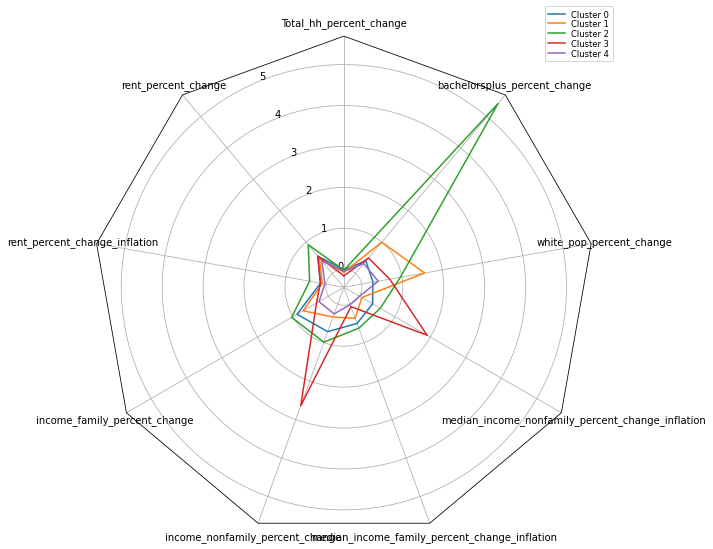

In [29]:
def radar_plot(kmeans, cluster1):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in cluster1.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')
radar_plot (kmeans, cluster1)

Cluster 0, which includes 28 census tracts, has relatively even percent change across the indicators with a slightly larger change in rents. Cluster 1 includes 26 census tracts, which have the second highest change in the percent of people with bachelor's degrees and white population. Cluster 2 includes only 2 census tracts which are characterized by an extremely large change in the percent of people with bachelor's degrees and the percent of white people. Cluster 3 includes 10 census tracts and has large percent change in median nonfamily income with and without inflation and rents. Cluster 4 is the largest cluster with 62 census tracts. It includes census tracts that have shown the least amount of change in the indicators over time. 

Overall, it appears clusters 0 and 4, which make up the majority of the census tracts (90 census tracts in total), are the most stable over the 10 year period, meaning they are likely stable or already underwent full gentrification before 2010. The other 3 clusters represent varying degrees of neighborhood change with cluster 2 exhibiting the most dramatic change in demographics and rent, cluster 1 exhibiting some change in demographics, and cluster 3 exhibiting dramatic change in nonfamily income. 

### Cluster 2

In [30]:
cluster2 = pd.read_csv('/Users/micaobrien/Documents/Github/UDS-Project--Full-Team-/Cluster1.csv')
cluster2 = cluster2.drop(columns={'Unnamed: 0'})

In [31]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(cluster2)

In [32]:
cluster2['cluster_id'] = kmeans.labels_

In [33]:
cluster2.groupby('cluster_id').size()

cluster_id
0    23
1     6
2    17
3     2
4     8
5    16
6     4
7    10
8    34
9     8
dtype: int64

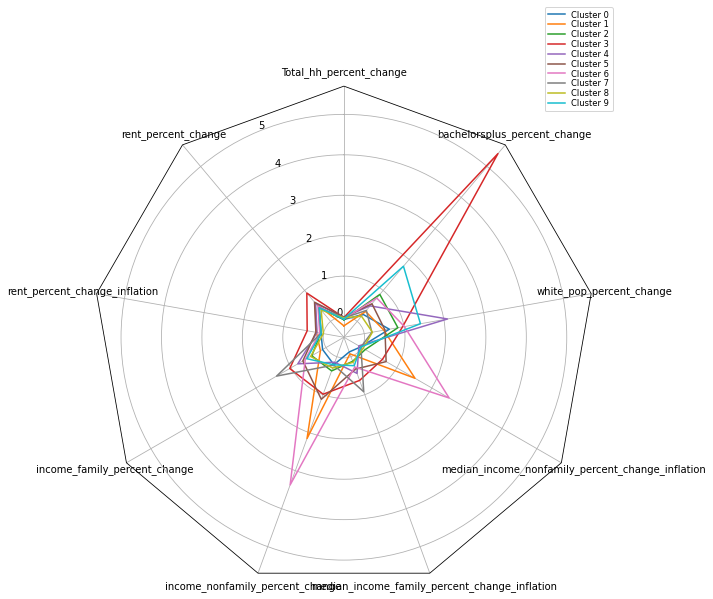

In [34]:
def radar_plot(kmeans, cluster2):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in cluster2.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')
radar_plot (kmeans, cluster2)

This 10 cluster radar plot builds off of the previous 5 cluster plot. We still have a cluster (in this case cluster 3) that has an extremely high percent change in people with bachelor's degrees. Cluster 6 has a high percent change in nonfamily income with and without inflation. Cluster 4 has the highest percent change in white population. In general, this plot is much harder to read because there is so much going on. For this reason, we work with 5 clusters moving forward. 

### Cluster 3

In [35]:
cluster3 = pd.read_csv('/Users/micaobrien/Documents/Github/UDS-Project--Full-Team-/Cluster3.csv')
cluster3 = cluster3.drop(columns={'Unnamed: 0'})

In [36]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(cluster3)

In [37]:
cluster3['cluster_id'] = kmeans.labels_

In [38]:
cluster3.groupby('cluster_id').size()

cluster_id
0    10
1     2
2    56
3    26
4    34
dtype: int64

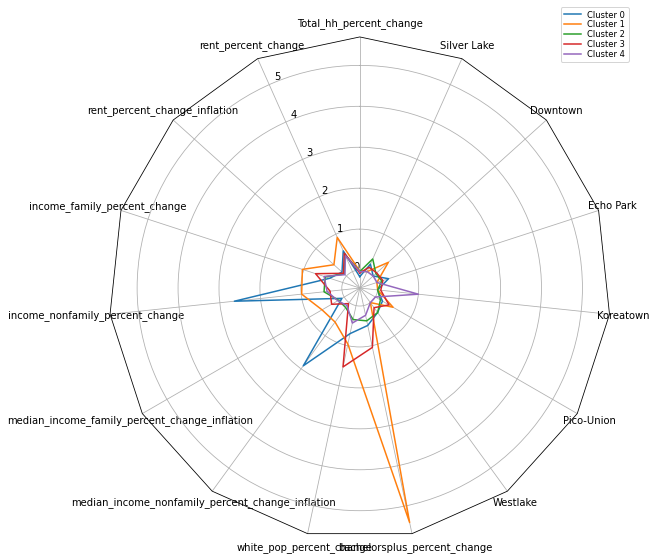

In [39]:
def radar_plot(kmeans, cluster3):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in cluster3.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')
radar_plot (kmeans, cluster3)

Interstingly, the radar plot changes a bit and the clusters become slighlty more evenly sized when we incorporate the neighborhood dummy variables. Cluster 0, which includes 10 census tracts, has a high percent change in nonfamily income with and without inflation. Cluster 1, which has only 2 census tracts, has an extremely high percent change in bachelor's degrees and a notably high percent change in family and nonfamily income and rent. Both census tracts are located in Downtown. Cluster 2 has 56 census tracts and appears pretty stable with more census tracts in Silver Lake. Cluster 3 has 26 census tracts and has a somewhat high percent change in white population. Cluster 4 has 34 census tracts and also appears stable with more census tracts in Koreatown. Like with the previous radar plot, 2 clusters (in this case clusters 2 and 4) appear stable and 3 clusters (clusters 0, 1, and 3) show greater signs of neighborhood change.  

## Visualizing Clusters and Comparing to Urban Displacement Project Data

In [40]:
map1 = gpd.read_file('/Users/micaobrien/Documents/Github/UDS-Project--Full-Team-/Map1.geojson')

I start by creating a map of the first cluster analysis, which includes census variables without dummy neighborhood variables. We see that cluster 4 (a cluster with some of the more stable census tracts) appear to be grouped on the outskirts of the map in the north, west, and south. Cluster 1, which includes census tracts with some deomgraphic change, appears to be concentrated in the southern part of the map. Clusters 0 and 3 appear to be sprinkled throughout. 

Text(0.5, 1.0, 'Clusters of Gentrification Indicators')

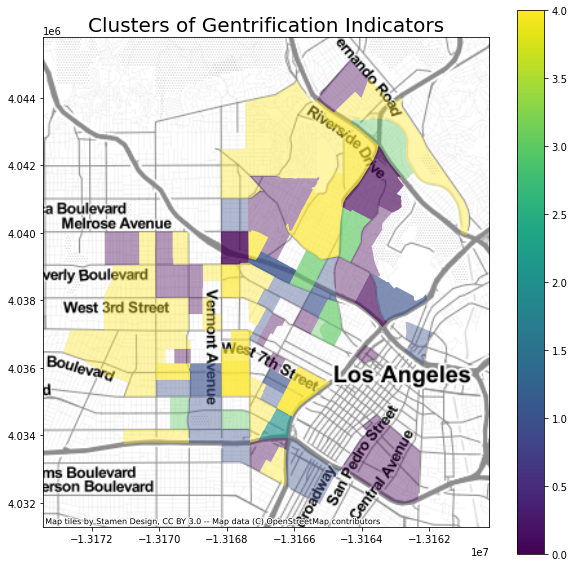

In [41]:
fig, ax = plt.subplots(figsize=(10,10))

map1.to_crs('EPSG:3857').plot('cluster_id', legend=True, ax = ax, alpha=0.4)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)

ax.set_title('Clusters of Gentrification Indicators', fontsize=20)

In [42]:
map2 = gpd.read_file('/Users/micaobrien/Documents/Github/UDS-Project--Full-Team-/Map2.geojson')

The clusters appear more cohesive when we include neighborhood dummy variables. We see clear clusters in Koreatown and  Silver Lake/Echo Park in particular. 

Text(0.5, 1.0, 'Clusters of Gentrification Indicators')

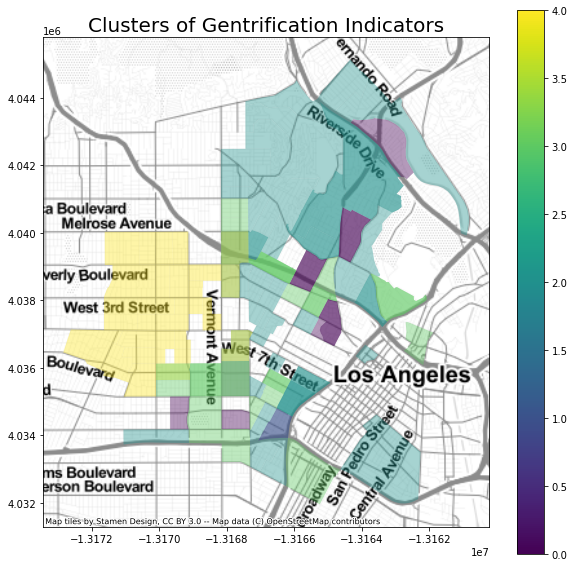

In [43]:
fig, ax = plt.subplots(figsize=(10,10))

map2.to_crs('EPSG:3857').plot('cluster_id', legend=True, ax = ax, alpha=0.4)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)

ax.set_title('Clusters of Gentrification Indicators', fontsize=20)

When I re-map the clusters next to the Urban Displacement Project's Gentrification Typology map, greater patterns emerge. UDP has 8 distinct stages of gentrification, including: advanced gentrification, at-risk of gentrification, becoming exclusive, early/ongoing gentrification, low-income/susceptible to displacement, ongoing displacement, stable moderate/mixed income, and stable/advanced exclusive. We assigned numeric values to each stage to more easily compare it with the 5 clusters. We assigned advanced gentrification as 4 and stable/advanced exclusive as 0. 

Cluster 4 (more stable census tracts) is concentrated in Koreatown. On the UDP map, this area has medium and rising gentrification/displacement risk (gentrification has intensified on the west side of the neighborhood). Cluster 3 (which has a high percent change in white population) is clustered in the southwest area, which is Pico-Union/Westlake. On the UDP map, this area has medium to high gentrification/displacement risk. Cluster 2 (more stable census tracts) is concentrated in Silver Lake and Echo Park, which correlates with the stable moderate/stable exclusive typology on the UDP map. Cluster 1 (census tracts with extremely high percent change in bachelor's degrees and a notably high percent change in family and nonfamily income and rents) is located in Downtown. The UDP map shows this area as at risk/advanced gentrification. Lastly, Cluster 0 (census tracts with a high percent change in nonfamily income with and without inflation) is distributed across the map and does not translate easily onto the UDP map.

Text(0.5, 1.0, 'Urban Displacement Project: Displacement Risk Index')

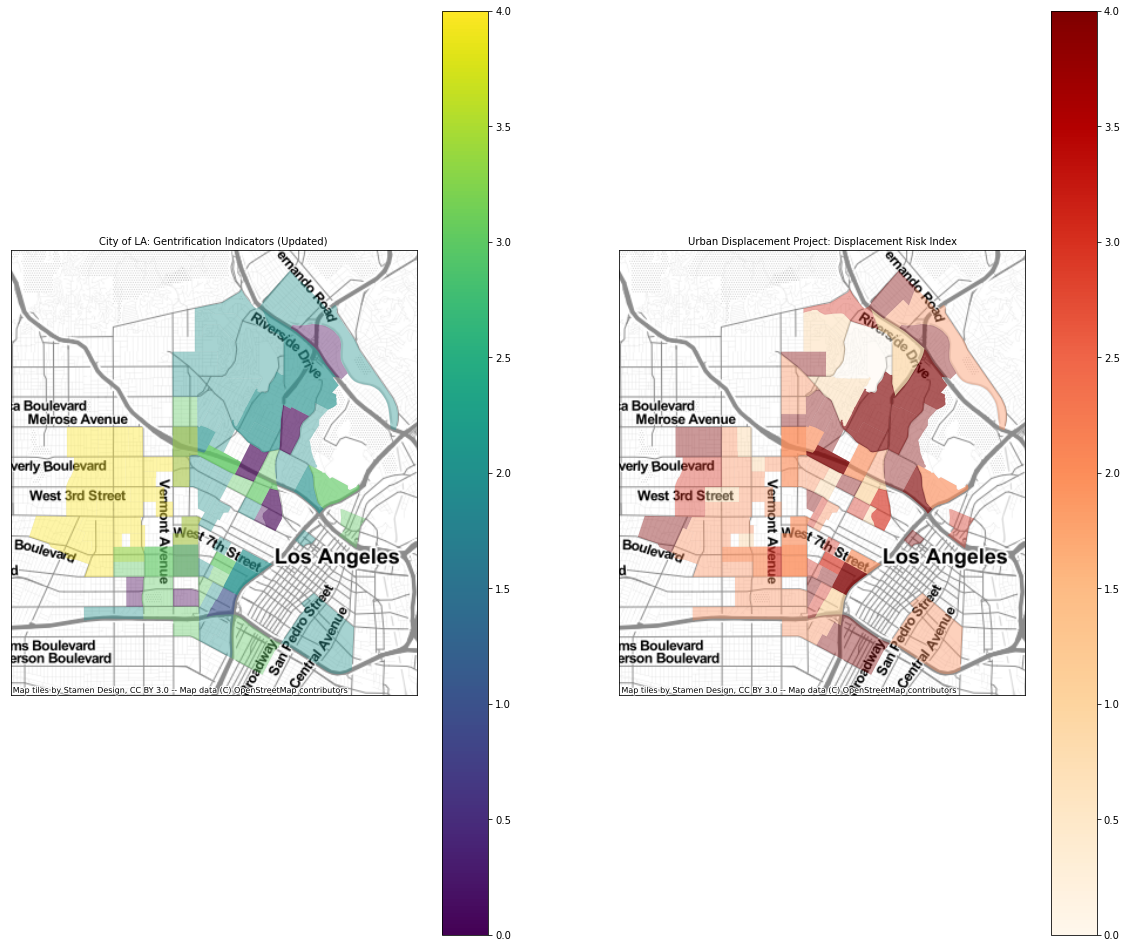

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(20, 17), sharex=True, sharey=True)

ax1, ax2 = axs

map2.to_crs('EPSG:3857').plot('cluster_id', legend=True, ax = ax1, alpha=0.4)
ctx.add_basemap(ax1, zoom=12, source=ctx.providers.Stamen.TonerLite)

ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('City of LA: Gentrification Indicators (Updated)', fontsize=10)


map2.to_crs('EPSG:3857').plot('Typology_numeric2', legend=True, cmap='OrRd', ax = ax2, alpha=0.4)
ctx.add_basemap(ax2, zoom=12, source=ctx.providers.Stamen.TonerLite)

ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Urban Displacement Project: Displacement Risk Index', fontsize=10)